In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
import scanpy as sc

from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scvi
import pandas as pd


Global seed set to 0


In [2]:
### test whole data with RNA only 
path = "/mnt/data0/halo/BH/humanbrain_multome.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [3]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

n_genes :1584
fine tune is False
gate decoder initialization n_input 10, n_output 156781,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [11]:
## load pre-trained models
model = model.load("model_humanbrain_causal002", adata_mvi)
# model = model.load("model_humanbrain_causal01", adata_mvi)

# model = model.load("model_multivelo_fig5_nocausal", adata_mvi)

# model = model.load("model_multivelo_fig5_causal_0065_softmax", adata_mvi)
# model = model.load("model_myeloid_data_nocausal", adata_mvi)

INFO     File model_humanbrain_causal002/model.pt already downloaded                         
n_genes :1584
fine tune is False
gate decoder initialization n_input 10, n_output 156781,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [12]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

In [22]:
# model = model.load("model_humanbrain_causal01",adata_mvi)
from complementary_models import torch_infer_nonsta_dir


latent_atac_indep_t = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep_t = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')

# times = np.array(times.detach().cpu())
score3 = []
score4=[]

latent_atac_dep_t = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep_t = torch.tensor(latent_expr_dep).to('cuda')

score1 = []
score2=[]
sample_num = 700
iterations = 30

for i in range(iterations):
    index = np.random.choice(latent_acc.shape[0] , sample_num)
    score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[index,:], latent_expr_indep_t[index,:], times[index])[0].detach().cpu())
    score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[index,:], latent_atac_indep_t[index,:], times[index])[0].detach().cpu())
    score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[index,:], latent_expr_dep_t[index,:], times[index])[0].detach().cpu())
    score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[index,:], latent_atac_dep_t[index,:], times[index])[0].detach().cpu())





score3 = np.array(score3)
score4 = np.array(score4)

score1 = np.array(score1)
score2 = np.array(score2)

In [23]:
scores = pd.DataFrame({"decouple_atac_to_rna":score3, "decouple_rna_to_atac":score4, "couple_atac_to_rna":score1, "couple_rna_to_atac":score2})
scores.to_csv("results/BH_065_causal.csv")
scores.head()


,decouple_atac_to_rna,decouple_rna_to_atac,couple_atac_to_rna,couple_rna_to_atac
0,0.043176,0.057463,0.067735,0.067614
1,0.044317,0.057837,0.065637,0.065558
2,0.043625,0.056944,0.065067,0.065033
3,0.043506,0.057297,0.066451,0.066417
4,0.048065,0.057825,0.068100,0.068036


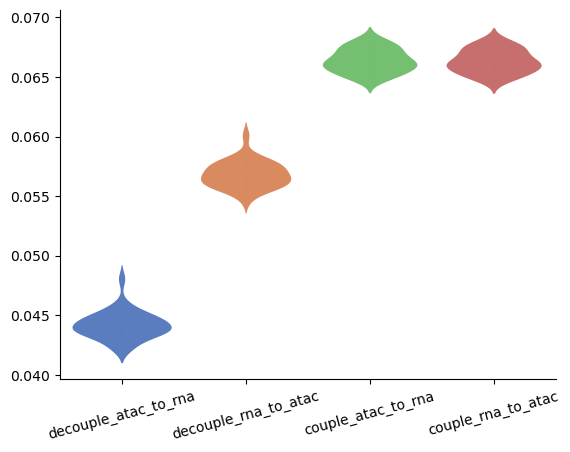

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt


ax = sns.violinplot(data=scores, palette="muted",inner="points", linewidth=0.001, edgecolor = "none")

plt.xticks(rotation=15)
sns.despine()


In [25]:
decouple_stat = (score3 - score4)
couple_stat = (score1 - score2)

stats = pd.DataFrame({"decouple":decouple_stat, "couple":couple_stat})
stats.to_csv("results/BH_065_causal_stats.csv")
stats.head()

,decouple,couple
0,-0.014288,0.000121
1,-0.013520,0.000080
2,-0.013319,0.000034
3,-0.013791,0.000035
4,-0.009760,0.000064


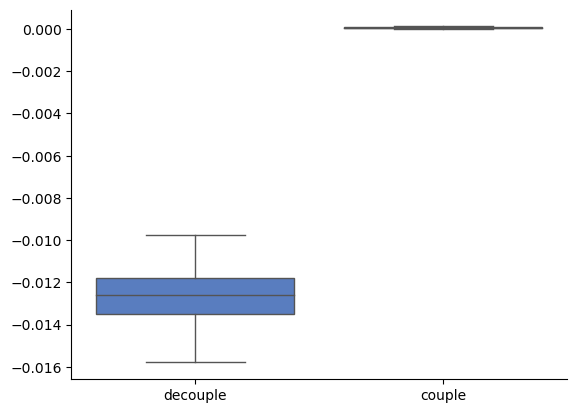

In [26]:
ax = sns.boxplot(data=stats, palette="muted", linewidth=1)

sns.despine()

In [13]:
## ablation study in terms of  clustering 
from sklearn.metrics.cluster import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI

name = "results/HB_clustering_score_{}.csv".format("002")
sample_num = 1000
iterations = 10
nmi = []
ari = []

for i in range(iterations):
    index = np.random.choice(latent_acc.shape[0] , sample_num)
    datatemp = adata_mvi[index,:]
    datatemp.obsm["latent_rep"] = latent_expr[index, :]
    sc.pp.neighbors(datatemp, use_rep="latent_rep")
    sc.tl.leiden(datatemp, key_added="leiden_latent", resolution=0.4)
    ari_score = ARI(datatemp.obs['cluster'], datatemp.obs['leiden_latent'])
    nmi_whole = NMI(datatemp.obs['cluster'], datatemp.obs['leiden_latent'])
    nmi.append(nmi_whole)
    ari.append(ari_score)

scoredf = pd.DataFrame({"nmi": nmi, "ari":ari})
scoredf.to_csv(name)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: U